In [20]:
from utils import summarize_text, verify_watermark
from datasets import load_dataset
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import (
    AutoTokenizer,
    AutoConfig,
    LogitsProcessor,
    BartForConditionalGeneration,
)
import hashlib
import math

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [46]:
# Load CNN/DailyMail dataset
dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')  # Using 'test' split for evaluation

In [47]:
# For faster testing, use a subset (e.g., first 1000 samples)
subset_size = 3000
dataset = dataset.select(range(subset_size))
print(f"Number of samples in subset: {len(dataset)}")

Number of samples in subset: 3000


In [48]:
# Initialize a list to store results
results = []

In [51]:
from rouge_score import rouge_scorer

def compute_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [ ]:
import random
import pickle

# track iteration for writing to pickle object
count = 0

# Iterate over the dataset and generate summaries
for sample in tqdm(dataset, desc="Generating summaries"):
    article = sample['article']

    # generate variability in generated model outputs
    max_length = random.randint(30, 300)

    # gamma
    gamma = random.uniform(0.2, 0.8)

    # delta value
    delta = random.randint(4.0, 12.0)

    # Generate summary with watermark
    summary, summary_ids = summarize_text(
        article,
        max_length=max_length,
        min_length=30,
        gamma=gamma,    # Consistent gamma
        delta=delta,    # Adjusted delta
        n=10,
        verbose=False  # Set verbose to True to see logits info
    )

    # Get the number of tokens in the summary
    summary_tokens = tokenizer.encode(summary, add_special_tokens=False)
    summary_length = len(summary_tokens)

    # calculate rouge score
    reference_summary = sample['highlights']  # Assuming 'highlights' is the reference
    rouge_scores = compute_rouge(reference_summary, summary)
    print(rouge_scores)

    # Verify the watermark
    green_ratio, z_score, is_watermarked = verify_watermark(
        summary_ids,
        gamma=gamma,    # Consistent gamma
        key=b'secret_key',
        n=10,
        z_threshold=4.0  # Ensure threshold is set correctly
    )

    # Record the results
    results.append({
        'summary_length': summary_length,
        'green_ratio': green_ratio,
        'z_score': z_score,
        'is_watermarked': is_watermarked,
        'delta': delta,
        'gamma': gamma,
        'rouge1': rouge_scores['rouge1'].fmeasure,
        'rouge2': rouge_scores['rouge2'].fmeasure,
        'rougeL': rouge_scores['rougeL'].fmeasure,
    })

    if count % 10 == 0:
        with open('watermarking_bart_large_moseley_data_2.pkl', 'wb') as f:
            pickle.dump(results, f)
        print(f"Pickle updated at iteration {count}")

    count += 1

In [66]:
import pandas as pd

# Convert results to a pandas DataFrame
df_results = pd.DataFrame(results)

# Display the first few rows
# print(df_results.head())

print(df_results["rouge1"])



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3034    0.183333
3035    0.253968
3036    0.381679
3037    0.226950
3038    0.238908
Name: rouge1, Length: 3039, dtype: float64


In [67]:
# Define bins for summary lengths
bins = [50, 100, 150, 200, 250, 300]
labels = ['50-100', '100-150', '150-200', '200-250', '250-300']

# Bin the summary lengths
df_results['length_bin'] = pd.cut(df_results['summary_length'], bins=bins, labels=labels, right=False)

# Group by the length bins and compute accuracy
accuracy_by_length = df_results.groupby('length_bin')['is_watermarked'].mean().reset_index()
accuracy_by_length.rename(columns={'is_watermarked': 'accuracy'}, inplace=True)

print(accuracy_by_length)

  length_bin  accuracy
0     50-100  0.560764
1    100-150  0.688555
2    150-200  0.802491
3    200-250  0.836394
4    250-300  0.888676


/var/folders/ht/z492cfls78q6l_t7_np6h07c0000gn/T/ipykernel_29933/1766487617.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='length_bin', y='accuracy', data=accuracy_by_length, palette='viridis')


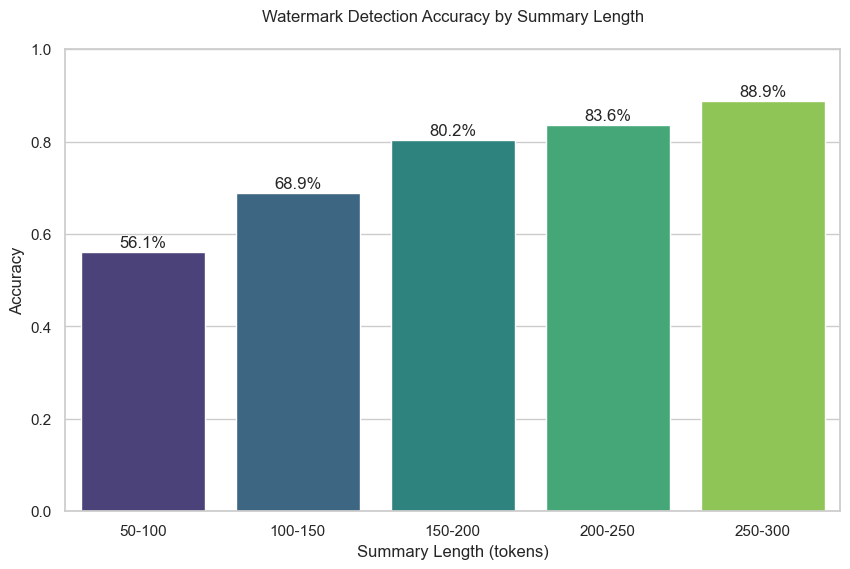

In [68]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot for accuracy vs. summary length
plt.figure(figsize=(10, 6))
sns.barplot(x='length_bin', y='accuracy', data=accuracy_by_length, palette='viridis')

# Add title and labels
plt.title('Watermark Detection Accuracy by Summary Length', pad=20)
plt.xlabel('Summary Length (tokens)')
plt.ylabel('Accuracy')

# Display the exact accuracy on top of each bar
for index, row in accuracy_by_length.iterrows():
    plt.text(index, row['accuracy'] + 0.01, f"{row['accuracy']*100:.1f}%", ha='center')

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 (0% to 100%)

plt.show()

In [69]:
# Define bins for summary lengths
length_bins = [50, 100, 150, 200, 250, 300]
length_labels = ['50-100', '100-150', '150-200', '200-250', '250-300']

# Bin the summary lengths
df_results['length_bin'] = pd.cut(df_results['summary_length'], bins=length_bins, labels=length_labels, right=False)

# Define bins for delta and gamma
delta_bins = list(range(5, 13))  # Delta between 5 and 12
gamma_bins = [0.2, 0.4, 0.6, 0.8]  # Gamma between 0.2 and 0.8

# Bin the delta and gamma values
df_results['delta_bin'] = pd.cut(df_results['delta'], bins=delta_bins, right=False, include_lowest=True)
df_results['gamma_bin'] = pd.cut(df_results['gamma'], bins=gamma_bins, right=False, include_lowest=True)

# Group by length_bin, delta_bin, and gamma_bin, and compute accuracy
accuracy_by_factors = df_results.groupby(['length_bin', 'delta_bin', 'gamma_bin'])['is_watermarked'].mean().reset_index()
accuracy_by_factors.rename(columns={'is_watermarked': 'accuracy'}, inplace=True)

print(accuracy_by_factors)

    length_bin delta_bin   gamma_bin  accuracy
0       50-100    [5, 6)  [0.2, 0.4)  0.565217
1       50-100    [5, 6)  [0.4, 0.6)  0.454545
2       50-100    [5, 6)  [0.6, 0.8)  0.185185
3       50-100    [6, 7)  [0.2, 0.4)  0.583333
4       50-100    [6, 7)  [0.4, 0.6)  0.565217
..         ...       ...         ...       ...
100    250-300  [10, 11)  [0.4, 0.6)  1.000000
101    250-300  [10, 11)  [0.6, 0.8)  0.894737
102    250-300  [11, 12)  [0.2, 0.4)  1.000000
103    250-300  [11, 12)  [0.4, 0.6)  1.000000
104    250-300  [11, 12)  [0.6, 0.8)  0.937500

[105 rows x 4 columns]


/var/folders/ht/z492cfls78q6l_t7_np6h07c0000gn/T/ipykernel_29933/3469887656.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='length_bin', y='accuracy', data=accuracy_by_factors.groupby('length_bin')['accuracy'].mean().reset_index(), palette='viridis')


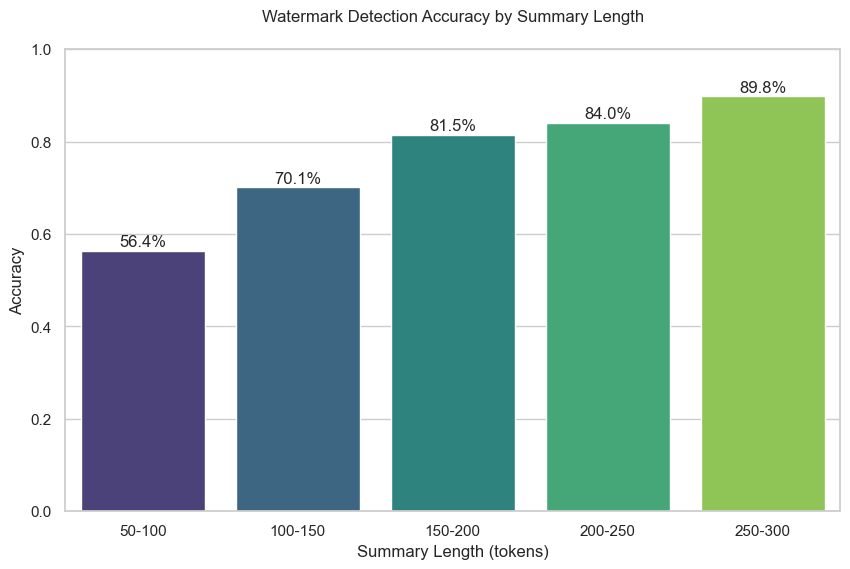

/var/folders/ht/z492cfls78q6l_t7_np6h07c0000gn/T/ipykernel_29933/3469887656.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='delta_bin', y='accuracy', data=accuracy_by_factors.groupby('delta_bin')['accuracy'].mean().reset_index(), palette='magma')


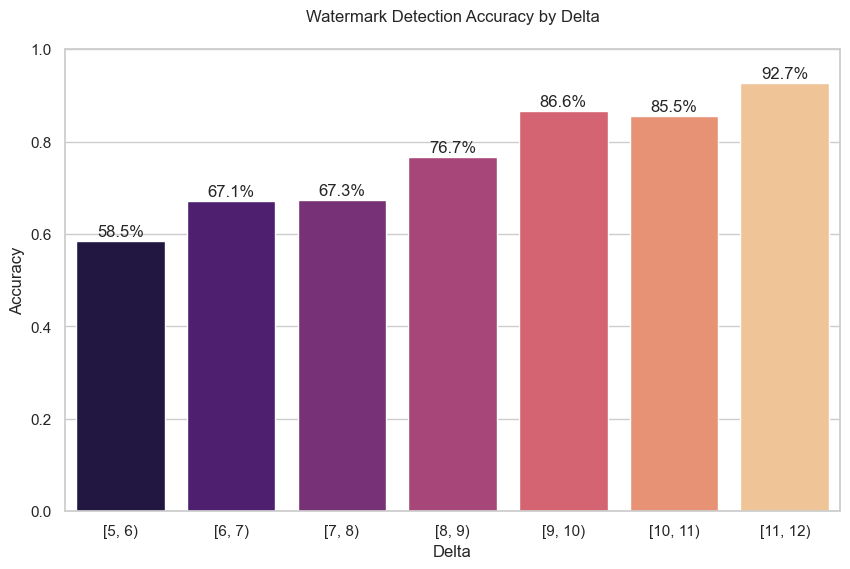

/var/folders/ht/z492cfls78q6l_t7_np6h07c0000gn/T/ipykernel_29933/3469887656.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gamma_bin', y='accuracy', data=accuracy_by_factors.groupby('gamma_bin')['accuracy'].mean().reset_index(), palette='coolwarm')


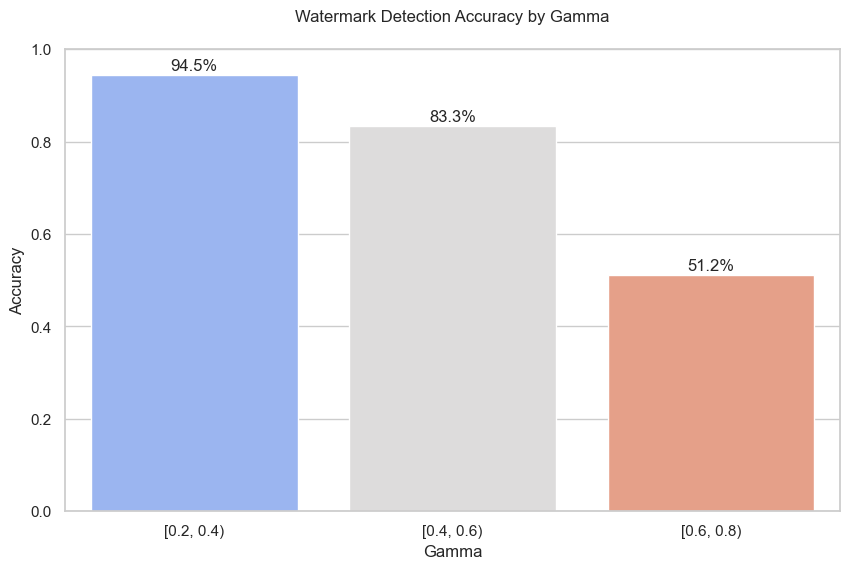

In [70]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot 1: Accuracy vs. Summary Length
plt.figure(figsize=(10, 6))
sns.barplot(x='length_bin', y='accuracy', data=accuracy_by_factors.groupby('length_bin')['accuracy'].mean().reset_index(), palette='viridis')
plt.title('Watermark Detection Accuracy by Summary Length', pad=20)
plt.xlabel('Summary Length (tokens)')
plt.ylabel('Accuracy')
for index, row in accuracy_by_factors.groupby('length_bin')['accuracy'].mean().reset_index().iterrows():
    plt.text(index, row['accuracy'] + 0.01, f"{row['accuracy']*100:.1f}%", ha='center')
plt.ylim(0, 1)
plt.show()

# Plot 2: Accuracy vs. Delta Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='delta_bin', y='accuracy', data=accuracy_by_factors.groupby('delta_bin')['accuracy'].mean().reset_index(), palette='magma')
plt.title('Watermark Detection Accuracy by Delta', pad=20)
plt.xlabel('Delta')
plt.ylabel('Accuracy')
for index, row in accuracy_by_factors.groupby('delta_bin')['accuracy'].mean().reset_index().iterrows():
    plt.text(index, row['accuracy'] + 0.01, f"{row['accuracy']*100:.1f}%", ha='center')
plt.ylim(0, 1)
plt.show()

# Plot 3: Accuracy vs. Gamma Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='gamma_bin', y='accuracy', data=accuracy_by_factors.groupby('gamma_bin')['accuracy'].mean().reset_index(), palette='coolwarm')
plt.title('Watermark Detection Accuracy by Gamma', pad=20)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
for index, row in accuracy_by_factors.groupby('gamma_bin')['accuracy'].mean().reset_index().iterrows():
    plt.text(index, row['accuracy'] + 0.01, f"{row['accuracy']*100:.1f}%", ha='center')
plt.ylim(0, 1)
plt.show()


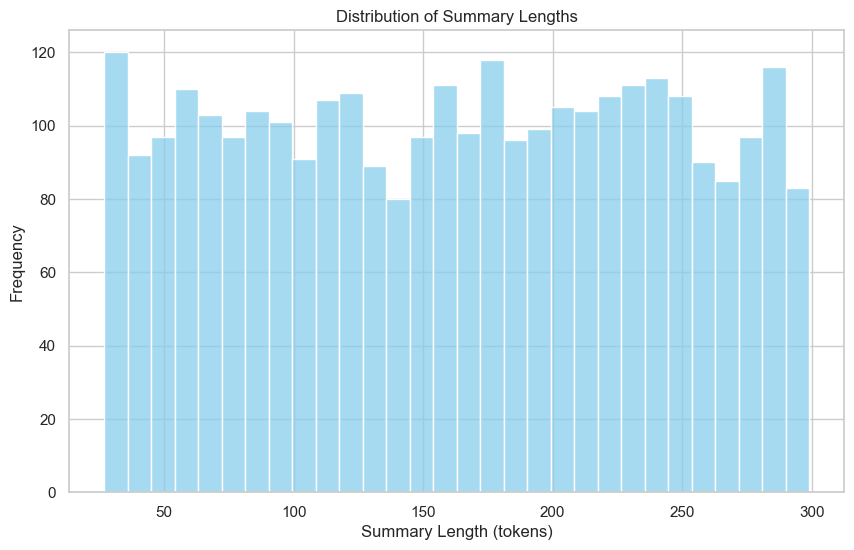

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(df_results['summary_length'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Summary Length (tokens)')
plt.ylabel('Frequency')
plt.show()

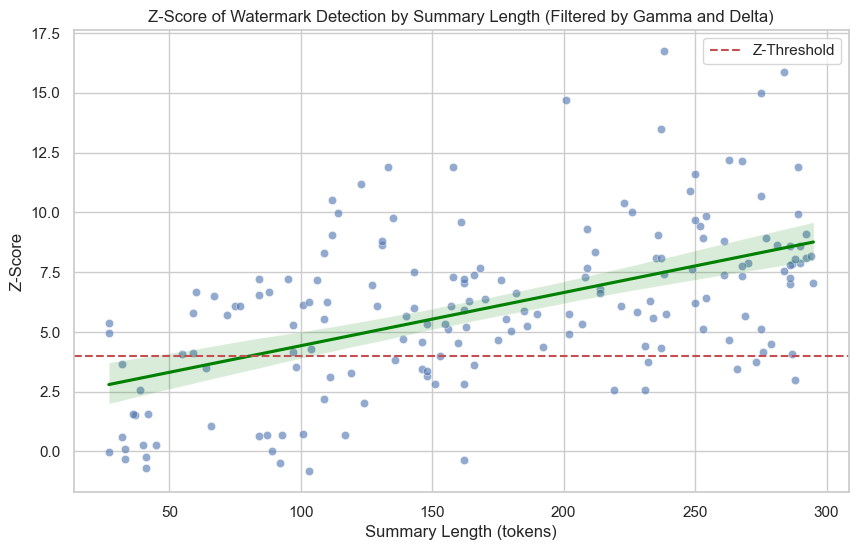

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame based on gamma and delta conditions
filtered_df = df_results[(df_results['gamma'] >= 0.4) & (df_results['gamma'] <= 0.5) & (df_results['delta'] >= 5.0) & (df_results['delta'] <= 7.0)]

# Select a random subset of points (e.g., 500 points) from the filtered data
sampled_df = filtered_df.sample(n=500, random_state=1) if len(filtered_df) > 500 else filtered_df

plt.figure(figsize=(10, 6))

# Plot the scatter points
sns.scatterplot(x='summary_length', y='z_score', data=sampled_df, alpha=0.6)

# Add the trendline in green
sns.regplot(x='summary_length', y='z_score', data=sampled_df, scatter=False, color='green')

# Add title, labels, and threshold line
plt.title('Z-Score of Watermark Detection by Summary Length (Filtered by Gamma and Delta)')
plt.xlabel('Summary Length (tokens)')
plt.ylabel('Z-Score')
plt.axhline(y=4.0, color='r', linestyle='--', label='Z-Threshold')
plt.legend()
plt.show()



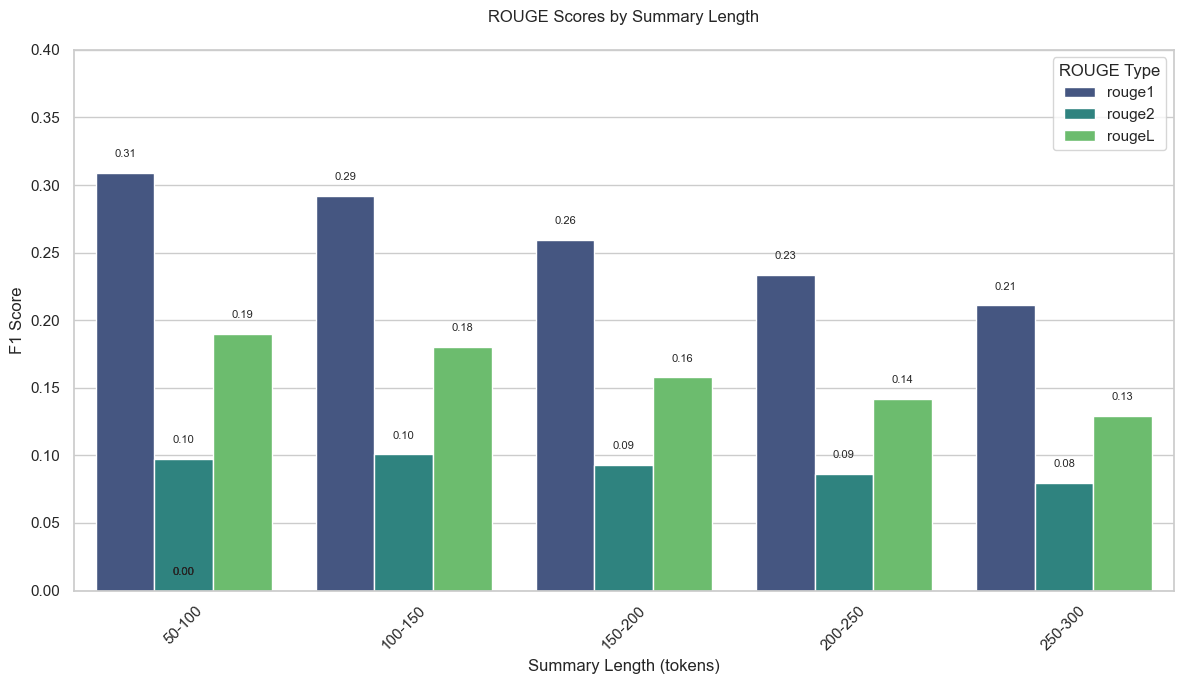

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Melt the DataFrame to have a 'ROUGE_Type' column
rouge_melted = df_results.melt(id_vars=['summary_length', 'length_bin'],
                       value_vars=['rouge1', 'rouge2', 'rougeL'],
                       var_name='ROUGE_Type',
                       value_name='F1_Score')

# Compute mean F1 scores for each length_bin and ROUGE_Type
rouge_summary = rouge_melted.groupby(['length_bin', 'ROUGE_Type'])['F1_Score'].mean().reset_index()

# Plot ROUGE Scores vs. Summary Length
plt.figure(figsize=(12, 7))
sns.barplot(x='length_bin', y='F1_Score', hue='ROUGE_Type', data=rouge_summary, palette='viridis')

plt.title('ROUGE Scores by Summary Length', pad=20)
plt.xlabel('Summary Length (tokens)')
plt.ylabel('F1 Score')
plt.legend(title='ROUGE Type')
plt.ylim(0, 0.4)

# Annotate bars with F1 scores
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 0.01, f'{height:.2f}',
                   ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

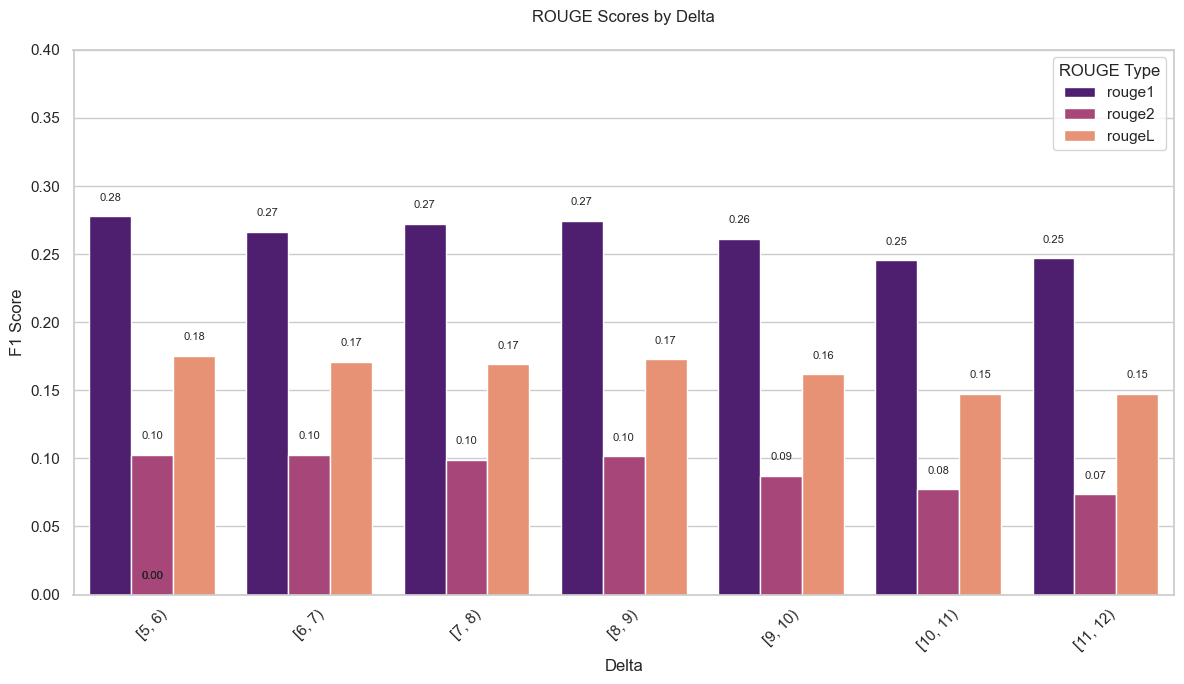

In [80]:
# Melt the DataFrame
rouge_melted = df_results.melt(id_vars=['delta', 'delta_bin'],
                       value_vars=['rouge1', 'rouge2', 'rougeL'],
                       var_name='ROUGE_Type',
                       value_name='F1_Score')

# Compute mean F1 scores for each delta_bin and ROUGE_Type
rouge_delta = rouge_melted.groupby(['delta_bin', 'ROUGE_Type'])['F1_Score'].mean().reset_index()

# Plot ROUGE Scores vs. Delta
plt.figure(figsize=(12, 7))
sns.barplot(x='delta_bin', y='F1_Score', hue='ROUGE_Type', data=rouge_delta, palette='magma')

plt.title('ROUGE Scores by Delta', pad=20)
plt.xlabel('Delta')
plt.ylabel('F1 Score')
plt.legend(title='ROUGE Type')
plt.ylim(0, 0.4)

# Annotate bars with F1 scores
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 0.01, f'{height:.2f}',
                   ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

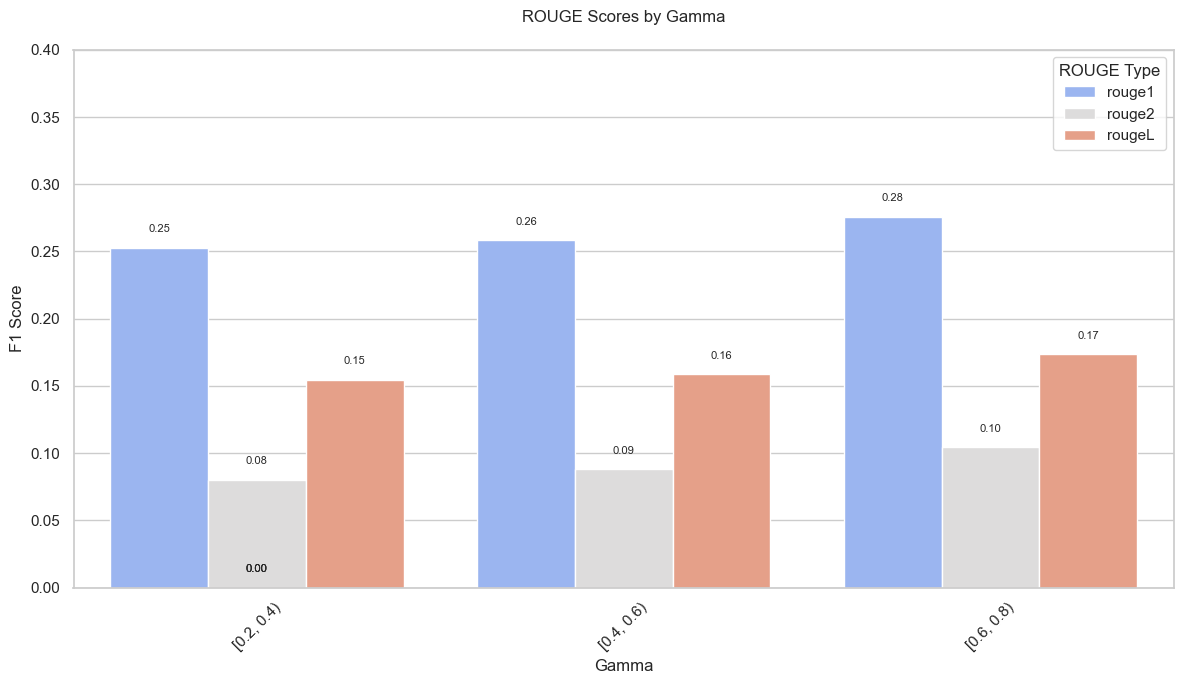

In [79]:
# Melt the DataFrame
rouge_melted = df_results.melt(id_vars=['gamma', 'gamma_bin'],
                       value_vars=['rouge1', 'rouge2', 'rougeL'],
                       var_name='ROUGE_Type',
                       value_name='F1_Score')

# Compute mean F1 scores for each gamma_bin and ROUGE_Type
rouge_gamma = rouge_melted.groupby(['gamma_bin', 'ROUGE_Type'])['F1_Score'].mean().reset_index()

# Plot ROUGE Scores vs. Gamma
plt.figure(figsize=(12, 7))
sns.barplot(x='gamma_bin', y='F1_Score', hue='ROUGE_Type', data=rouge_gamma, palette='coolwarm')

plt.title('ROUGE Scores by Gamma', pad=20)
plt.xlabel('Gamma')
plt.ylabel('F1 Score')
plt.legend(title='ROUGE Type')
plt.ylim(0, 0.4)

# Annotate bars with F1 scores
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 0.01, f'{height:.2f}',
                   ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

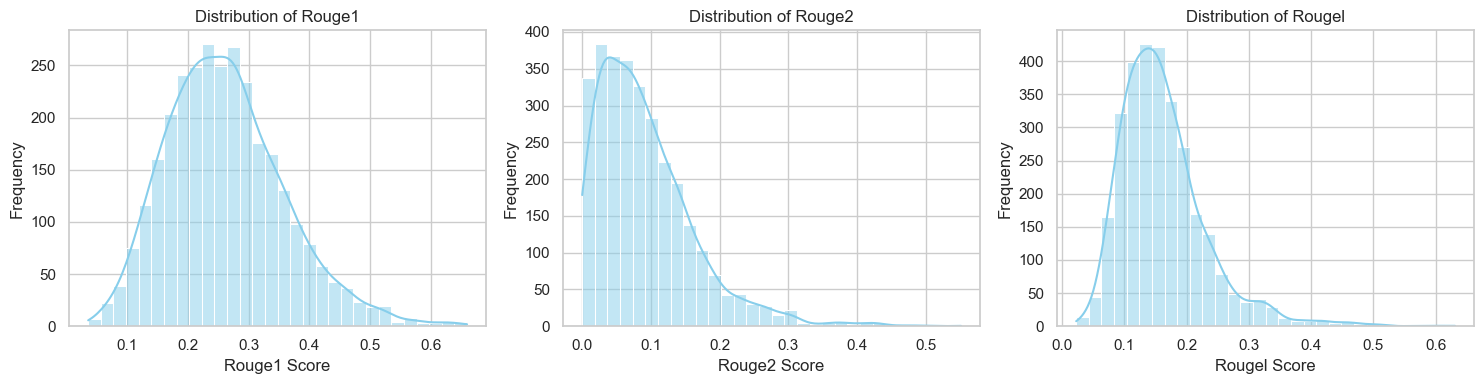

In [107]:
# Set aesthetic style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(15, 4))

for i, rouge in enumerate(['rouge1', 'rouge2', 'rougeL'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_results[rouge], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {rouge.capitalize()}')
    plt.xlabel(f'{rouge.capitalize()} Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

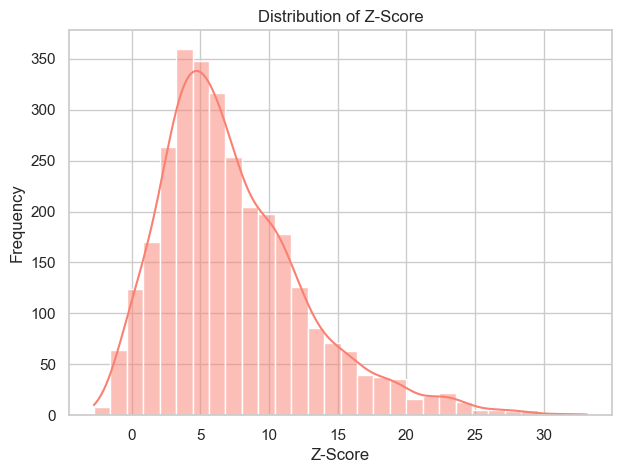

In [89]:
# Distribution of z_score
plt.figure(figsize=(7, 5))
sns.histplot(df_results['z_score'], kde=True, bins=30, color='salmon')
plt.title('Distribution of Z-Score')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

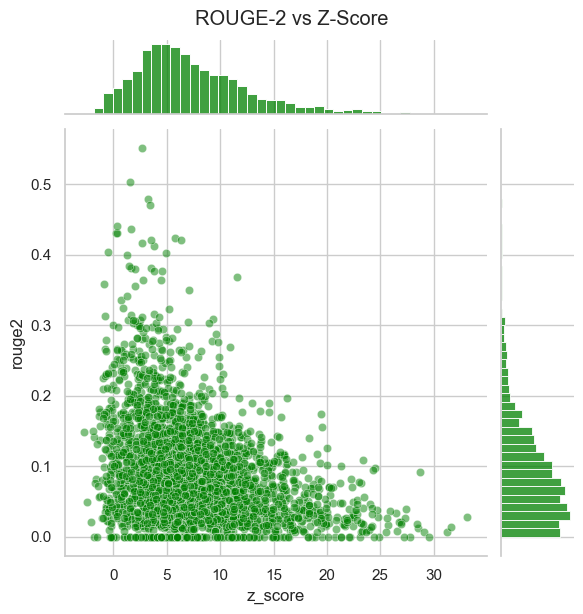

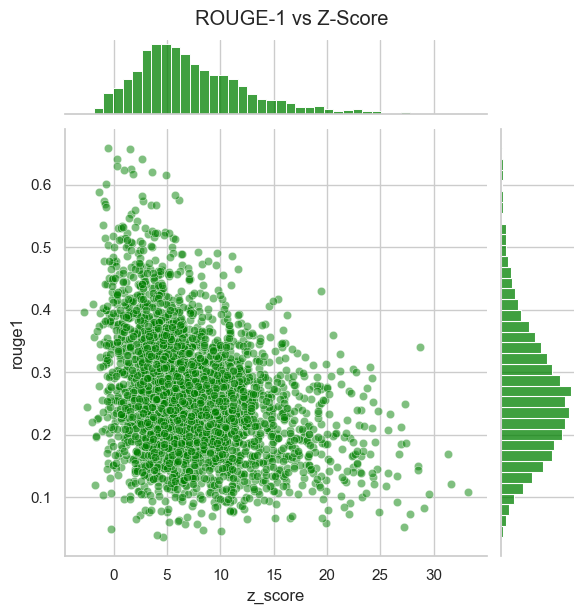

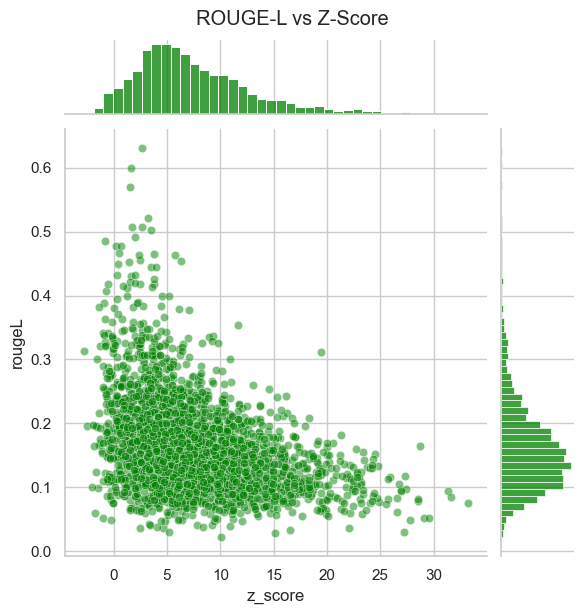

In [105]:
# Joint plot for ROUGE-2 vs Z-Score
sns.jointplot(x='z_score', y='rouge2', data=df_results, kind='scatter', alpha=0.5, color='green')
plt.suptitle('ROUGE-2 vs Z-Score', y=1.02)
plt.show()

# Repeat similarly for ROUGE-1 and ROUGE-L if desired
sns.jointplot(x='z_score', y='rouge1', data=df_results, kind='scatter', alpha=0.5, color='green')
plt.suptitle('ROUGE-1 vs Z-Score', y=1.02)
plt.show()

sns.jointplot(x='z_score', y='rougeL', data=df_results, kind='scatter', alpha=0.5, color='green')
plt.suptitle('ROUGE-L vs Z-Score', y=1.02)
plt.show()


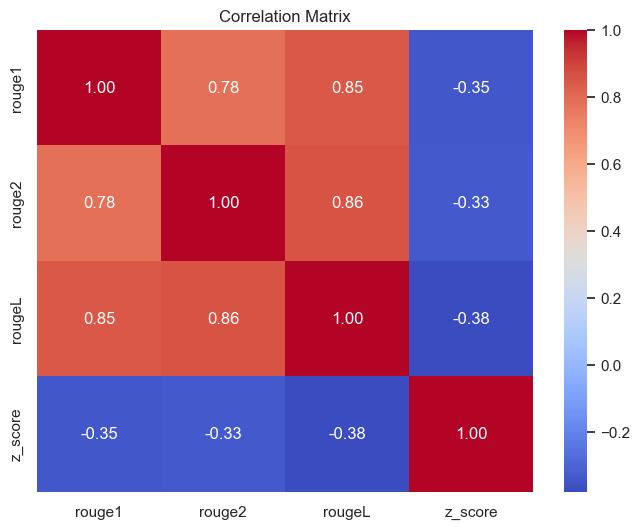

In [93]:
# Compute correlation matrix
corr_matrix = df_results[['rouge1', 'rouge2', 'rougeL', 'z_score']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

/var/folders/ht/z492cfls78q6l_t7_np6h07c0000gn/T/ipykernel_29933/4284991561.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='z_bin', y='rougeL', data=df_results, palette='Set3')


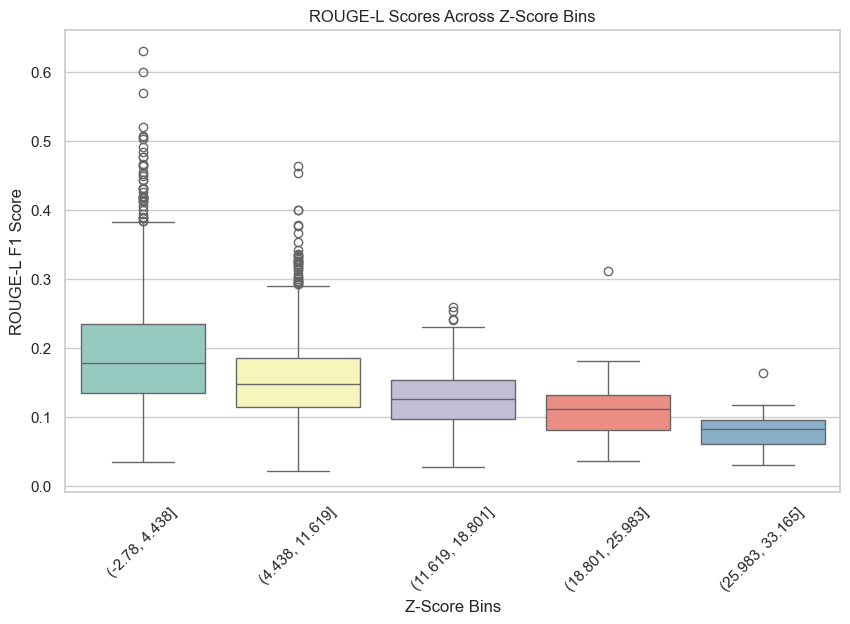

In [95]:
# Assuming you've created a categorical bin for z_score
df_results['z_bin'] = pd.cut(df_results['z_score'], bins=5)

# Box plot for ROUGE-L vs Z-Score Bins
plt.figure(figsize=(10, 6))
sns.boxplot(x='z_bin', y='rougeL', data=df_results, palette='Set3')
plt.title('ROUGE-L Scores Across Z-Score Bins')
plt.xlabel('Z-Score Bins')
plt.ylabel('ROUGE-L F1 Score')
plt.xticks(rotation=45)
plt.show()

In [97]:
# Pearson correlation
pearson_corr = df_results[['rouge1', 'rouge2', 'rougeL', 'z_score']].corr(method='pearson')
print("Pearson Correlation:\n", pearson_corr)

# Spearman correlation
spearman_corr = df_results[['rouge1', 'rouge2', 'rougeL', 'z_score']].corr(method='spearman')
print("\nSpearman Correlation:\n", spearman_corr)

Pearson Correlation:
            rouge1    rouge2    rougeL   z_score
rouge1   1.000000  0.781027  0.846058 -0.345426
rouge2   0.781027  1.000000  0.856317 -0.334785
rougeL   0.846058  0.856317  1.000000 -0.378121
z_score -0.345426 -0.334785 -0.378121  1.000000

Spearman Correlation:
            rouge1    rouge2    rougeL   z_score
rouge1   1.000000  0.750524  0.857049 -0.327125
rouge2   0.750524  1.000000  0.805968 -0.328109
rougeL   0.857049  0.805968  1.000000 -0.384029
z_score -0.327125 -0.328109 -0.384029  1.000000


In [103]:
from scipy import stats

df_results = df_results.dropna(subset=['z_score'])
df_results = df_results.dropna(subset=['rouge1'])

# Example for ROUGE-1 vs Z-Score
pearson_coef, p_value = stats.pearsonr(df_results['z_score'], df_results['rouge1'])
print(f"ROUGE-1 vs Z-Score Pearson Correlation: {pearson_coef:.3f}, p-value: {p_value:.3f}")

# Interpret the p-value
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

ROUGE-1 vs Z-Score Pearson Correlation: -0.345, p-value: 0.000
The correlation is statistically significant.
